In [12]:
# %% Configuración
from IPython.display import display, Markdown
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# TÍTULO DEL BLOQUE
display(Markdown("# 1. CONFIGURACIÓN PREVIA Y CARGA DE DATOS"))

# 1. Configuración del dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo seleccionado: {device}")

if not os.path.exists('./images'):
    os.makedirs('./images')

# 2. Pipeline de Datos (Normalización -1 a 1)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

print("Cargando dataset MNIST...")
# Datos de ENTRENAMIENTO (para que la red aprenda)
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=64, shuffle=True)

# Datos de TEST/VALIDACIÓN (para comprobar que no memoriza)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=64, shuffle=False)

print("¡Carga completada!")
print(f" - Imágenes de entrenamiento: {len(train_data)}")
print(f" - Imágenes de test: {len(test_data)}")

# 1. CONFIGURACIÓN PREVIA Y CARGA DE DATOS

Dispositivo seleccionado: cpu
Cargando dataset MNIST...
¡Carga completada!
 - Imágenes de entrenamiento: 60000
 - Imágenes de test: 10000


In [14]:
# %% Tarea A
display(Markdown("# 2. TAREA A: ELIMINACIÓN DE RUIDO (DENOISING)"))

# --- Definición del Modelo ---
class AutoencoderDenoising(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

def add_noise(img, factor=0.5):
    noise = torch.randn_like(img) * factor
    return torch.clamp(img + noise, -1., 1.)

# --- Entrenamiento ---
print("Entrenando Denoising...")
model_dn = AutoencoderDenoising().to(device)
optimizer = torch.optim.Adam(model_dn.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
epochs = 20
history_dn = []

for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.to(device)
        noisy = add_noise(img)
        output = model_dn(noisy)
        loss = criterion(output, img)

        #BACKWARD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    
    if epoch == epochs-1: history_dn = (img, noisy, output)

# --- Visualización ---
img, noisy, recon = [x.cpu().detach().numpy() for x in history_dn]
plt.figure(figsize=(9, 4)); plt.gray()
for i in range(9):
    plt.subplot(3, 9, i+1); plt.imshow(img[i][0]); plt.axis('off')
    if i==0: plt.title("Original")
    plt.subplot(3, 9, i+10); plt.imshow(noisy[i][0]); plt.axis('off')
    if i==0: plt.title("Ruidosa")
    plt.subplot(3, 9, i+19); plt.imshow(recon[i][0]); plt.axis('off')
    if i==0: plt.title("Reconstrucción (Limpia)")

plt.tight_layout()
plt.savefig('./images/resultado_denoising.png')
print("Gráfica guardada: ./images/resultado_denoising.png")
plt.show()

# 2. TAREA A: ELIMINACIÓN DE RUIDO (DENOISING)

Entrenando Denoising...
Epoch 1/20 - Loss: 0.0375
Epoch 2/20 - Loss: 0.0248
Epoch 3/20 - Loss: 0.0259


KeyboardInterrupt: 

# 3. TAREA B: SUPERRESOLUCIÓN (7x7 -> 28x28)

Entrenando modelo para input 7x7...
Epoch 1/20 - Loss: 0.0834
Epoch 2/20 - Loss: 0.0806
Epoch 3/20 - Loss: 0.0671
Epoch 4/20 - Loss: 0.0713
Epoch 5/20 - Loss: 0.0680
Epoch 6/20 - Loss: 0.0665
Epoch 7/20 - Loss: 0.0700
Epoch 8/20 - Loss: 0.0648
Epoch 9/20 - Loss: 0.0557
Epoch 10/20 - Loss: 0.0704
Epoch 11/20 - Loss: 0.0698
Epoch 12/20 - Loss: 0.0614
Epoch 13/20 - Loss: 0.0708
Epoch 14/20 - Loss: 0.0552
Epoch 15/20 - Loss: 0.0590
Epoch 16/20 - Loss: 0.0492
Epoch 17/20 - Loss: 0.0502
Epoch 18/20 - Loss: 0.0585
Epoch 19/20 - Loss: 0.0553
Epoch 20/20 - Loss: 0.0597
Gráfica guardada: ./images/resultado_sr_7x7.png


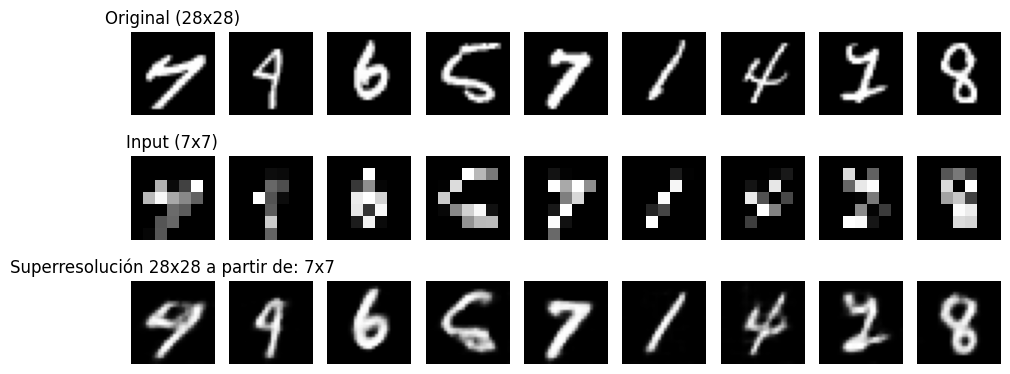

In [16]:
# %% Tarea B - 7x7
display(Markdown("# 3. TAREA B: SUPERRESOLUCIÓN (7x7 -> 28x28)"))

# --- Definición del Modelo y Utilidades ---
class AutoencoderSR(nn.Module):
    def __init__(self, input_size=7):
        super().__init__()
        # Encoder adaptativo
        if input_size == 7:
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 64, 7)
            )
        elif input_size == 14:
            self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(), nn.Conv2d(32, 64, 7)
            )
        # Decoder estándar
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Tanh()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

def make_low_res(img, size):
    return torch.nn.functional.interpolate(img, size=(size, size), mode='bilinear', align_corners=False)

# --- Entrenamiento Caso 7x7 ---
print("Entrenando modelo para input 7x7...")
model_7 = AutoencoderSR(input_size=7).to(device)
optimizer = torch.optim.Adam(model_7.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.MSELoss()
epochs = 20
last_batch_7 = []

for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.to(device)
        low = make_low_res(img, size=7)
        out = model_7(low)
        loss = criterion(out, img)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    
    if epoch == epochs-1: last_batch_7 = (img, low, out)

# --- Visualización 7x7 ---
orig, inp, out = [x.cpu().detach().numpy() for x in last_batch_7]
plt.figure(figsize=(9, 4)); plt.gray()
for i in range(9):
    plt.subplot(3, 9, i+1); plt.imshow(orig[i][0]); plt.axis('off')
    if i==0: plt.title("Original (28x28)")
    
    plt.subplot(3, 9, i+10); plt.imshow(inp[i][0]); plt.axis('off')
    if i==0: plt.title("Input (7x7)")
    
    plt.subplot(3, 9, i+19); plt.imshow(out[i][0]); plt.axis('off')
    # TÍTULO ESPECÍFICO PEDIDO
    if i==0: plt.title("Superresolución 28x28 a partir de: 7x7")

plt.tight_layout()
plt.savefig('./images/resultado_sr_7x7.png')
print("Gráfica guardada: ./images/resultado_sr_7x7.png")
plt.show()

# 4. TAREA B: SUPERRESOLUCIÓN (14x14 -> 28x28)

Entrenando modelo para 14x14...
Epoch 1/10 - Loss: 0.0367
Epoch 2/10 - Loss: 0.0213
Epoch 3/10 - Loss: 0.0171
Epoch 4/10 - Loss: 0.0165
Epoch 5/10 - Loss: 0.0143
Epoch 6/10 - Loss: 0.0139
Epoch 7/10 - Loss: 0.0126
Epoch 8/10 - Loss: 0.0146
Epoch 9/10 - Loss: 0.0123
Epoch 10/10 - Loss: 0.0131
Imagen guardada: ./images/resultado_sr_14x14.png


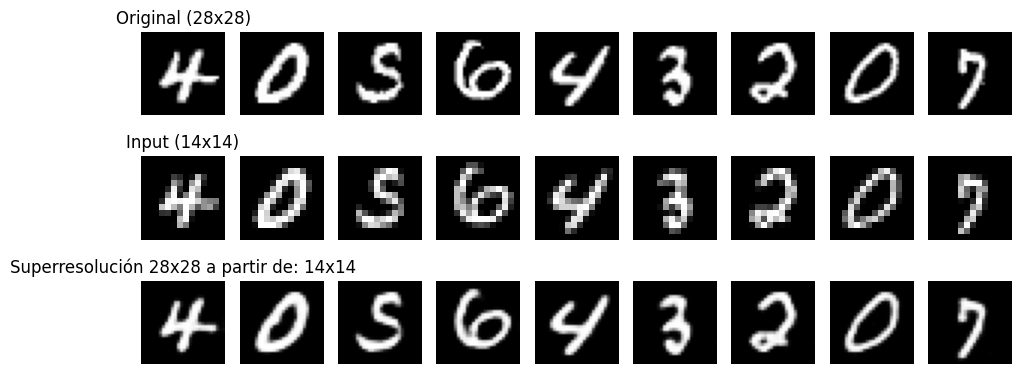

In [18]:
# %% Tarea B - 14x14
display(Markdown("# 4. TAREA B: SUPERRESOLUCIÓN (14x14 -> 28x28)"))

# --- Entrenamiento 14x14 ---
print("Entrenando modelo para 14x14...")
model_14 = AutoencoderSR(input_size=14).to(device)
optimizer = torch.optim.Adam(model_14.parameters(), lr=1e-3)
criterion = nn.MSELoss()
epochs = 10
last_batch_14 = []

for epoch in range(epochs):
    for img, _ in train_loader:
        img = img.to(device)
        low = make_low_res(img, size=14)
        out = model_14(low)
        loss = criterion(out, img)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    
    # CAMBIO: Imprimimos SIEMPRE
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}")
    
    if epoch == epochs-1: last_batch_14 = (img, low, out)

# --- Visualización 14x14 ---
orig, inp, out = [x.cpu().detach().numpy() for x in last_batch_14]
plt.figure(figsize=(9, 4)); plt.gray()
for i in range(9):
    plt.subplot(3, 9, i+1); plt.imshow(orig[i][0]); plt.axis('off')
    if i==0: plt.title("Original (28x28)")
    
    plt.subplot(3, 9, i+10); plt.imshow(inp[i][0]); plt.axis('off')
    if i==0: plt.title("Input (14x14)")
    
    plt.subplot(3, 9, i+19); plt.imshow(out[i][0]); plt.axis('off')
    if i==0: plt.title("Superresolución 28x28 a partir de: 14x14")

plt.tight_layout()
plt.savefig('./images/resultado_sr_14x14.png')
print("Imagen guardada: ./images/resultado_sr_14x14.png")
plt.show()